# Проект - информационный поиск и базы данных

## Выполнила Захарова Яна, БКЛ213

##### 1. Взять корпус текстов по вашему проекту или выбрать любой корпус текстов и рассказать, октуда вы его взяли и почему именно его (ответ "потому что он мне понравился" тоже валиден):
- Он должен быть на русском (иное обсуждаемо, если корпус взят в рамках проекта) и содержать не меньше тысячи записей (абзацев, текстов, предложений etc).
- Если корпус не по проекту, то:
- Это может быть часть любого открытого корпуса, результат краулинга или даже генерации с помощью модели.
- Будет здорово, если он будет тематический (машины, лингвистика, литератруа etc.), но не обязательно.

Я выбрала датасет русской Википедии с Hugging Face. Он мне кажется подходящим. А еще я не смогла найти достаточное количество корпусов на русском языке, поэтому пришлось брать Википедию. А еще в этом корпусе 6 тысяч строк и он на русском.  

In [10]:
# Сюда я вынесла все import'ы.
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
import os 
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import time


C:\Users\Zaxarova\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_csv("hf://datasets/rogozinushka/psychologist_answers/psiholog_2023_12_16.csv")

In [36]:
#в данных много nan, удаляю такие строки 
df.head()
df_cleaned = df.dropna()

# Результат
df_cleaned

,url,question_title,question_body,answers
2,https://psiholog.ru/vopros/4,Тест от психолога,спрашивает: Нина (неуказан)Здравствуйте! Для ч...,"['Здравствуйте, Нина.\nВас легко понять.\nЕсли..."
3,https://psiholog.ru/vopros/3,Помогите разобраться,спрашивает: Евгений (неуказан)Здравствуйте.Мен...,['Здавствуйте! Может быть этот вопрос обсудить...
4,https://psiholog.ru/vopros/6,Постоянно думаю о прошлом и не знаю что делать,спрашивает: Лера (Москва)Я рассталась со своим...,['Время лечит. Нужно только принять ответствен...
6,https://psiholog.ru/vopros/5,Как научиться снова доверять жене?,спрашивает: Александр (неуказан)Наткнулся на п...,[]
7,https://psiholog.ru/vopros/8,Аутоагрессия,спрашивает: василиса (Москва)Здравствуйте Ольг...,['Добрый вечер Василиса!\nАгрессия это естеств...
...,...,...,...,...
37644,https://psiholog.ru/vopros/37645,Отношения с мужчиной на 17 лет старше,спрашивает: Екатерина (Екатеринбург)Встречаюсь...,"['Чтобы все Вам завидовали,Вам необходимо встр..."
37647,https://psiholog.ru/vopros/37648,Это ревность?,спрашивает: Кира (Москва)Я договариваюсь погов...,[]
37649,https://psiholog.ru/vopros/37651,Стоит ли оказывать финансовую поддержку?,спрашивает: Людмила (Москва)Доброго времени с...,['Здравствуйте! Скорее всего Вашей сестре очен...
37650,https://psiholog.ru/vopros/37652,Чувство ответственности за все создает конфлик...,спрашивает: Лариса (Новосибирск)Вот уже третий...,"['Лариса , здравствуйте!\xa0Вы взяли на себя о..."


#### **2. (1 балл) Провести предобработку текста так, чтобы это было логично при выбранном методе векторизации (объясните, почему выбрали то, что выбрали):**
- лемматизация
- чистка от пунктуации и стоп-слов
- что-то еще, что вы считаете нужным

In [31]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Приведение к нижнему регистру.
    text = text.lower()
    
    # Удаление только пунктуации (оставляем числа).
    text = re.sub(r'[^\w\s]', '', text)
    
    words = text.split()
    
    # Лемматизация и удаление стоп-слов.
    processed_words = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form  # можно заменить на стемминг, если нужна скорость
            processed_words.append(lemma)
    
    return ' '.join(processed_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zaxarova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
#применение функции
def preprocess_text(text):
    if not isinstance(text, str):  # Проверяем, является ли text строкой
        text = ''  # Заменяем нестроковые значения на пустую строку
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    text = re.sub(r'\d+', '', text)  # Удаление чисел
    return text
#df_cleaned1 = df_cleaned
df_cleaned['questions_tf_idf'] = df_cleaned['question_body'].apply(preprocess_text)
print(df_cleaned['questions_tf_idf'])

2        спрашивает нина неуказанздравствуйте для чего ...
3        спрашивает евгений неуказанздравствуйтеменя зо...
4        спрашивает лера москвая рассталась со своим мо...
6        спрашивает александр неуказаннаткнулся на пере...
7        спрашивает василиса москваздравствуйте ольга п...
                               ...                        
37644    спрашивает екатерина екатеринбургвстречаюсь по...
37647    спрашивает кира москвая договариваюсь поговори...
37649    спрашивает людмила  москвадоброго времени суто...
37650    спрашивает лариса новосибирсквот уже третий го...
37651    спрашивает екатерина москваздравствуйте меня з...
Name: questions_tf_idf, Length: 17644, dtype: object


C:\Users\Zaxarova\AppData\Local\Temp\ipykernel_20020\873007661.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['questions_tf_idf'] = df_cleaned['question_body'].apply(preprocess_text)


### применяю чистку еще и к ответам, чтобы потом выделить ключевые слова

In [38]:
# Пример функции preprocess_text
import re

def preprocess_text(text):
    if not isinstance(text, str):  # Проверяем, является ли text строкой
        text = ''  # Заменяем нестроковые значения на пустую строку
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    text = re.sub(r'\d+', '', text)  # Удаление чисел
    return text
df_cleaned['answers_tf_idf'] = df_cleaned['answers'].apply(preprocess_text)
df_cleaned['answers_tf_idf']

C:\Users\Zaxarova\AppData\Local\Temp\ipykernel_20020\1130492870.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['answers_tf_idf'] = df_cleaned['answers'].apply(preprocess_text)


2        здравствуйте нинаnвас легко понятьnесли ваша д...
3        здавствуйте может быть этот вопрос обсудить с ...
4        время лечит нужно только принять ответственнос...
6                                                         
7        добрый вечер василисаnагрессия это естественно...
                               ...                        
37644    чтобы все вам завидоваливам необходимо встреча...
37647                                                     
37649    здравствуйте скорее всего вашей сестре очень н...
37650    лариса  здравствуйтеxaвы взяли на себя ответст...
37651    добрый день  могу помочь разобраться с самооце...
Name: answers_tf_idf, Length: 17644, dtype: object

выделяю ключевые слова, добавляю в базу

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Пример данных
# df_cleaned = pd.DataFrame({
#     'url': [...],
#     'question_title': [...],
#     'question_body': [...],
#     'answers': [...]
# })

# Функция для извлечения топ-N ключевых слов
def extract_top_keywords(texts, top_n=3):
    """
    Извлекает топ-N ключевых слов из текстов с помощью TF-IDF.
    """
    if texts.empty:
        return pd.DataFrame(columns=[f'keyword_{i+1}' for i in range(top_n)])

    # Преобразование текста в векторное представление
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(texts)

    # Извлечение ключевых слов
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_keywords = []

    for row in tfidf_matrix:
        indices = row.toarray().argsort()[0, -top_n:][::-1]
        top_keywords.append(feature_names[indices])

    # Преобразование результата в DataFrame
    return pd.DataFrame(top_keywords, columns=[f'keyword_{i+1}' for i in range(top_n)])

# Обработка колонки question_body
question_body_keywords = extract_top_keywords(df_cleaned['questions_tf_idf'].fillna(''), top_n=3)

# Обработка колонки answers
answers_keywords = extract_top_keywords(df_cleaned['answers_tf_idf'].fillna(''), top_n=3)

# Добавление ключевых слов в исходный DataFrame
df_cleaned = pd.concat([df_cleaned, question_body_keywords.add_prefix('qbody_'), answers_keywords.add_prefix('answers_')], axis=1)

# Результат
df_cleaned

,url,question_title,question_body,answers,questions_tf_idf,answers_tf_idf,qbody_keyword_1,qbody_keyword_2,qbody_keyword_3,answers_keyword_1,answers_keyword_2,answers_keyword_3
2,https://psiholog.ru/vopros/4,Тест от психолога,спрашивает: Нина (неуказан)Здравствуйте! Для ч...,"['Здравствуйте, Нина.\nВас легко понять.\nЕсли...",спрашивает нина неуказанздравствуйте для чего ...,здравствуйте нинаnвас легко понятьnесли ваша д...,все,мы,изза,часто,ведь,время
3,https://psiholog.ru/vopros/3,Помогите разобраться,спрашивает: Евгений (неуказан)Здравствуйте.Мен...,['Здавствуйте! Может быть этот вопрос обсудить...,спрашивает евгений неуказанздравствуйтеменя зо...,здавствуйте может быть этот вопрос обсудить с ...,всего,вообще,жены,является,которым,лизяев
4,https://psiholog.ru/vopros/6,Постоянно думаю о прошлом и не знаю что делать,спрашивает: Лера (Москва)Я рассталась со своим...,['Время лечит. Нужно только принять ответствен...,спрашивает лера москвая рассталась со своим мо...,время лечит нужно только принять ответственнос...,появляется,вижу,или,вы,кого,вопросы
6,https://psiholog.ru/vopros/5,Как научиться снова доверять жене?,спрашивает: Александр (неуказан)Наткнулся на п...,[],спрашивает александр неуказаннаткнулся на пере...,,меня,что,это,муж,xa,что
7,https://psiholog.ru/vopros/8,Аутоагрессия,спрашивает: василиса (Москва)Здравствуйте Ольг...,['Добрый вечер Василиса!\nАгрессия это естеств...,спрашивает василиса москваздравствуйте ольга п...,добрый вечер василисаnагрессия это естественно...,нее,что,сильно,сделали,те,остается
...,...,...,...,...,...,...,...,...,...,...,...,...
17630,NaN,NaN,NaN,NaN,NaN,NaN,этих,что,он,это,на,все
17632,NaN,NaN,NaN,NaN,NaN,NaN,стал,ночи,может,на,слишком,отношениях
17634,NaN,NaN,NaN,NaN,NaN,NaN,просит,помощи,своими,возникают,слова,проработать
17635,NaN,NaN,NaN,NaN,NaN,NaN,ней,мне,ее,не,вам,мнение


**Как я чистила данные:** 

Привела к нижнему регистру, так как разные формы написания одного и того же слова могут быть интерпретированы как разные токены. Это нужно бля более быстрой последующей обработки.

Удалила пунктуацию, так как она не несет полезной семантики при создании векторных представлений текста.

Лемматизацировала текст, чтобы снизить число уникальных токенов. Это помогает модели захватить смысловые связи между различными формами одного и того же слова.

Удаленила стоп-слова, потому что они также не несут значимую информацию, а еще их удаление позволяет уменьшить количество уникальных слов.

#### **3. (2 балла) Реализовать индекссацию двумя различными (!) способами. При этом результат индексации должен куда-то сохраняться, а не пересчитываться заново при каждом запуске программы (и тем более при каждом запросе!)**

 **Способ на основе статистики (частоты, tf-idf, bm25 etc.)**

 **Способ на основе эмбеддингов (word2vec, bert etc.)**

#### **TF_IDF**

In [47]:
# Объект TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer()

# Текст перевожу в вектор
tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['questions_tf_idf'])
print(tfidf_matrix.shape)  

(17644, 62572)


In [48]:
# Создаю pickle dump, куда кладу данные tf-idf.
with open('tfidf_vectorizer1.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
if os.path.exists('tfidf_vectorizer1.pkl'):
    with open('tfidf_vectorizer1.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    print("Файл найден")
else:
    print("Файл tfidf_vectorizer1.pkl не найден.")


Файл найден


In [49]:
# Смотрю на то, что получилось в результате tf-idf.
with open('tfidf_vectorizer1.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
print(tfidf_vectorizer.get_feature_names_out())
print(tfidf_vectorizer.idf_)
print(tfidf_vectorizer.vocabulary_)

['00' '000' '0000' ... 'ёрзать' 'ёрничать' 'ёё']
[ 8.69876619  7.48237087  8.47562264 ...  9.39191337  9.67959545
 10.08506056]
{'спрашивать': 53240, 'нина': 31103, 'неуказанздравствовать': 30704, 'психолог': 44825, 'предложить': 42117, 'дочь': 13664, 'представить': 42210, 'посуда': 41381, 'растение': 47003, 'оружие': 34227, 'украшение': 57591, 'нарисовать': 28274, 'рисунок': 47797, 'тот': 56086, 'считать': 54599, 'специалист': 52970, 'человек': 60488, 'разный': 46261, 'этот': 62228, 'очень': 35945, 'молодой': 25913, 'мать': 24504, 'нужно': 31856, 'объяснение': 32968, 'тестадочь': 55594, 'взрослый': 6078, 'проблема': 43438, 'созависимость': 52358, 'мужемтак': 26910, 'смысл': 51910, 'тест': 55593, 'евгений': 14324, 'неуказанздравствуйтеменить': 30706, 'звать': 17495, 'евгенийпомочь': 14326, 'пожалуйста': 39377, 'разобраться': 46267, 'ситуация': 50769, 'женатый': 15161, '13': 166, 'год': 10139, 'вроде': 7976, 'возникнуть': 7015, 'конфликт': 21406, 'фон': 59172, 'приезд': 42707, 'тёща': 5

In [50]:
# Сохраняю данные матрицы tf-idf в pickle.
with open('tfidf_matrix1.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)
if os.path.exists('tfidf_matrix1.pkl'):
    with open('tfidf_matrix1.pkl', 'rb') as f:
        tfidf_matrix = pickle.load(f)
    print("Файл найден")
else:
    print("Файл tfidf_matrix1.pkl не найден.")

Файл найден


TF-IDF индексация:

1) Мы используем TfidfVectorizer для создания матрицы TF-IDF. Она превращает тексты в числовые векторы, учитывая частоту слов в документе и их редкость в корпусе.
2) Сохранение модели и самой матрицы происходит с помощью модуля pickle, чтобы при каждом запуске программы индексация не пересчитывалась заново.

#### **BERT**

In [51]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

def get_bert_embeddings(texts):
    embeddings = []

    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    
    return np.array(embeddings)

# Применение BERT'а.
bert_embeddings = get_bert_embeddings(df_cleaned['question_body'])

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/anazaharova/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib

In [52]:
# Сохраняю эмбеддинги в файл pickle.
with open('bert_embeddings1.pkl', 'wb') as f:
    pickle.dump(bert_embeddings, f)
if os.path.exists('bert_embeddings1.pkl'):
    with open('bert_embeddings1.pkl', 'rb') as f:
        bert_embeddings = pickle.load(f)
    print("Файл найден")
else:
    print("Файл bert_embeddings1.pkl не найден.")

Файл найден


In [53]:
# Смотрю на размер эмбеддингов
print(bert_embeddings.shape)

(17644, 768)


Модель: 
1) Мы используем модель ruBERT (DeepPavlov/rubert-base-cased), которая хорошо обучена на русскоязычных текстах. Мы загружаем токенизатор и модель с помощью библиотеки transformers.

Токенизация и преобразование текста в эмбеддинги:
1) Текст токенизируется (разбивается на слова и символы).
2) BERT принимает токенизированные тексты и возвращает эмбеддинги. Мы используем эмбеддинг специального CLS-токена, который обычно служит для представления всего предложения.

Сохранение: 

Эмбеддинги сохраняются в файл с помощью библиотеки pickle, чтобы их можно было загрузить при повторном запуске программы.

#### **4. (2 балла) Реализовать поиск: на входе текст запроса и вариант индекса, на выходе топ подходящих документов**

In [54]:
with open('tfidf_vectorizer1.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open('tfidf_matrix1.pkl', 'rb') as f:
    tfidf_matrix = pickle.load(f)

with open('bert_embeddings1.pkl', 'rb') as f:
    bert_embeddings = pickle.load(f)

# Функция для поиска по TF-IDF.
def search_tfidf(query, tfidf_vectorizer, tfidf_matrix, top_n=5):
    # Преобразую запрос в векторную форму.
    query_vec = tfidf_vectorizer.transform([query])
    
    # Рассчитываю косинусную близость между запросом и документами.
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Сортирую результаты по убыванию близости.
    top_indices = np.argsort(similarities)[::-1][:top_n]
    
    return top_indices, similarities[top_indices]
# Функция для получения эмбеддингов BERT 
def get_bert_embedding_for_query(query, tokenizer, model):
    inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    #print(f"Размерность эмбеддинга для запроса: {cls_embedding.shape}")
    return cls_embedding

# Функция для поиска по BERT'у
def search_bert(query_embedding, bert_embeddings, top_n=5):
    similarities = cosine_similarity([query_embedding], bert_embeddings).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_n]
    return top_indices, similarities[top_indices]

# Главная функция для выполнения поиска.
def search_engine(query, index_choice, df_cleaned, top_n=5):
    # Фиксирую время начала (это понадобится далее).
    start_time = time.time()
    
    if index_choice == 'tf-idf':
        print("Используем TF-IDF для поиска...")
        top_indices, top_similarities = search_tfidf(query, tfidf_vectorizer, tfidf_matrix, top_n)
    elif index_choice == 'bert':
        print("Используем BERT для поиска...")
        tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        query_embedding = get_bert_embedding_for_query(query, tokenizer, model)
        top_indices, top_similarities = search_bert(query_embedding, bert_embeddings, top_n)
    
    else:
        print("Неверный вариант индекса. Выберите 'tf-idf' или 'bert'.")
        return
    
    # # Фиксирую время завершения поиска.
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print(f"Поиск занял {elapsed_time:.4f} секунд.")
    
    # print(f"Топ-{top_n} подходящих документов:")
    # for i, idx in enumerate(top_indices):
    #     similarity = top_similarities[i]
    #     document_text = df_cleaned['answers'].iloc[idx]  
    #     print(f"Сходство: {similarity:.4f}")
    #     print(f"Текст документа {idx}:\n{document_text}\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Поиск занял {elapsed_time:.4f} секунд.\n")

    print(f"Топ-{top_n} подходящих документов:")
    for i, idx in enumerate(top_indices):
        similarity = top_similarities[i]
        question = df_cleaned['question_title'].iloc[idx]
        answer = df_cleaned['answers'].iloc[idx]
        print(f"Сходство: {similarity:.4f}")
        print(f"Вопрос: {question}")
        print(f"Ответ: {answer}\n")
        
        
query = input("Введите текст запроса: ")
index_choice = input("Введите, какой вариант индекса использовать ('tf-idf' или 'bert'): ")

search_engine(query, index_choice, df_cleaned)


Используем TF-IDF для поиска...
Поиск занял 0.0495 секунд.

Топ-5 подходящих документов:
Сходство: 0.3738
Вопрос: Периодические депрессии у молодого человека. Какие могут быть последствия для семейной жизни?
Ответ: ['Дина, поговорите с вашим молодым человеком откровенно, спросите его о названии его диагноза (тем более, что это наследственная вещь), о том, какие на самом деле прогнозы, о его взглядах на эту ситуацию. Если вы планируете семью. вам все равно важно это знать чтобы понимать все риски.\nПредугадать счастье или несчастье кого-либо в будущем просто невозможно, но быть осознанным (понимать что происходит) это важная составляющая, особенно, когда вы стоите перед выбором (а выбор, действительно, очень сложный и важный).\nPS\nВы всегда можете обратиться к специалисту за помощью, если самостоятельно разобраться\xa0и принять решение трудно.']

Сходство: 0.3088
Вопрос: Передается ли депрессии по наследству?
Ответ: ['Добрый день, Алексей. По поводу депрессивных признаков лучше всего о

In [55]:
import time
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

# Загрузка сохраненных моделей и матриц
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open('tfidf_matrix.pkl', 'rb') as f:
    tfidf_matrix = pickle.load(f)

with open('bert_embeddings.pkl', 'rb') as f:
    bert_embeddings = pickle.load(f)

# Функция для поиска по TF-IDF
def search_tfidf(query, tfidf_vectorizer, tfidf_matrix, top_n=5):
    query_vec = tfidf_vectorizer.transform([query])
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_n]
    return top_indices, similarities[top_indices]

# Функция для получения эмбеддингов BERT
def get_bert_embedding_for_query(query, tokenizer, model):
    inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Функция для поиска по BERT
def search_bert(query_embedding, bert_embeddings, top_n=5):
    similarities = cosine_similarity([query_embedding], bert_embeddings).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_n]
    return top_indices, similarities[top_indices]

# Главная функция для выполнения поиска
def search_engine(query, index_choice, df_cleaned, df_cleaned1, top_n=5):
    start_time = time.time()

    if index_choice == 'tf-idf':
        print("Используем TF-IDF для поиска...")
        top_indices, top_similarities = search_tfidf(query, tfidf_vectorizer, tfidf_matrix, top_n)
        data_source = df_cleaned1
    elif index_choice == 'bert':
        print("Используем BERT для поиска...")
        tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        query_embedding = get_bert_embedding_for_query(query, tokenizer, model)
        top_indices, top_similarities = search_bert(query_embedding, bert_embeddings, top_n)
        data_source = df_cleaned
    else:
        print("Неверный вариант индекса. Выберите 'tf-idf' или 'bert'.")
        return

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Поиск занял {elapsed_time:.4f} секунд.\n")

    print(f"Топ-{top_n} подходящих документов:")
    for i, idx in enumerate(top_indices):
        similarity = top_similarities[i]
        question = data_source['question_title'].iloc[idx]
        answer = data_source['answers'].iloc[idx]
        print(f"Сходство: {similarity:.4f}")
        print(f"Вопрос: {question}")
        print(f"Ответ: {answer}\n")

# Ввод запроса и выбора индекса
query = input("Введите текст запроса: ")
index_choice = input("Введите, какой вариант индекса использовать ('tf-idf' или 'bert'): ")

# Запуск функции поиска
search_engine(query, index_choice, df_cleaned, df_cleaned1)


Используем BERT для поиска...


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/anazaharova/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib

Поиск занял 2.3773 секунд.

Топ-5 подходящих документов:
Сходство: 0.9773
Вопрос: Хочу спокойствия. Как измениться?
Ответ: ['Апатия и навязчивые мысли часто бывают?']

Сходство: 0.9740
Вопрос: "Девочка для битья" в своей семье
Ответ: ['Выход есть. Жить отдельно.']

Сходство: 0.9735
Вопрос: Ревность мужа. Как справляться?
Ответ: ['Если он поднял на вас руку, то следовало написать заявление в полицию']

Сходство: 0.9735
Вопрос: Конфликт в семейных взаимоотношениях
Ответ: ['А какой у вас вопрос психологу ? Конкретизируйте его, какая помощь нужна\xa0']

Сходство: 0.9733
Вопрос: Как пережить душевную боль?
Ответ: ['Если будет тяжело пишите мне в чат']



#### **5. (1 балл) Описать в readme файле, как правильно запустить ваш код**

✅ 

#### **6. (1 балл) Ваш код должен соотвествовать следующим критериям:**
- PEP8 и комментарии (для возможности оценки 10 - еще тайпинги и докстринги)
- Осмысленные имена переменных, функций, классов, модулей
- Разделение на модули (разные файлы для разных больших блоков логики) или объяснение, почему тут это пока не нужно
- Разделение на классы/функции
- Одна очевидная для пользователя точка входа: класс поисковика / функция запуска, куда потом можно подавать тексты запросов

✅ Выполнено на предыдущих этапах

#### **7. (1 балл) Реализовать оптимальную версию поиска: предварительно рассчитывается все, что можно посчитать заранее и сохранить, потом считать только то, что зависит от запроса (подсказка: возможно, вам придется написать функцию близости руками, чтобы это работало)**

✅ Выполнено на предыдущих этапах. Все засунула в функции, остается только выбрать вариант индекса и ввести запрос. 

#### **8. (1 балл) Реализовать CLI (вот тут можно почитать, через что их можно делать в питоне) или веб-интерфейс (Flask, Streamlit или что-то другое на ваш выбор). Опишите в ридми, как пользоваться вашим кодом (без этого балл не ставится)**

#### **9. (1 балл) Подумайте, как можно формально сравнить два способа индексации с точки зрения качества поиска и/или векторизации. Опишите, какой способ вы придумали, и используйте его для сравнения двух выбранных типов индексации.**

**Метрики для оценки информационного поиска:**
- Быстрота поиска
- Precision - доля релевантных документов среди всех найденных.
- Recall - доля найденных релевантных документов среди всех возможных релевантных документов в корпусе.
- метрика F1 - гармоническое среднее между Precision и Recall.

**Процесс сравнения**

Шаг 1: Запустить несколько тестовых запросов и для каждого запроса вручную отметить несколько релевантных документов из базы.

Шаг 2: Запустить оба метода поиска с этими запросами и сохранить результат.

Шаг 3: Для каждого запроса и метода поиска сравнить полученные результаты с шагом 1, рассчитав метрики Precision, Recall, F1.

Шаг 4: Сравнить результаты между двумя методами по каждой метрике.

In [56]:
# Сет с тем, что мне показалось релевантным для обоих методов.
relevance_set = {
    'маленькая пушистая собака, домашняя порода рыжего цвета': [2293, 4822, 3131],  
    'причины возникновения инфаркта миокарда': [2894, 5333, 3655],
    'перснальный компьютер для хранения, переработки информации и выхода в интернет': [2341, 751, 1944],
    'первые люди на Земле, сотворённые Богом и прародители человеческого рода' : [0, 6282, ]
}
# Сет для того, что выдал TF-IDF.
search_results_tfidf = {
    'маленькая пушистая собака, домашняя порода рыжего цвета' : [2293, 4795, 5203, 4822, 3131],  
    'причины возникновения инфаркта миокарда': [0, 6283, 6282, 6281, 6280],
    'перснальный компьютер для хранения, переработки информации и выхода в интернет': [2341, 751, 1944, 2452, 2891],
    'первые люди на Земле, сотворённые Богом и прародители человеческого рода' : [0, 6283, 6282, 6281, 6280]
}
# Сет для того, что выдал BERT.
search_results_bert = {
    'маленькая пушистая собака, домашняя порода рыжего цвета' : [906, 3087, 2868, 5976, 767],  
    'причины возникновения инфаркта миокарда': [2894, 3343, 5333, 3655, 2289],
    'перснальный компьютер для хранения, переработки информации и выхода в интернет': [2452, 751, 2495, 772, 3510],
    'первые люди на Земле, сотворённые Богом и прародители человеческого рода' : [4764, 4980, 5336, 3069, 4990]
}

# Функция для оценки Precision, Recall, F1.
def evaluate_search(results, relevance_set):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for query, relevant_docs in relevance_set.items():
        predicted_docs = results.get(query, [])
        
        # Создаем вектор релевантности (1 - релевантен, 0 - не релевантен).
        relevant_labels = [1 if doc_id in relevant_docs else 0 for doc_id in predicted_docs]
        predicted_labels = [1] * len(predicted_docs)  
        # Рассчитываю метрики.
        precision = precision_score(relevant_labels, predicted_labels, average='binary')
        recall = recall_score(relevant_labels, predicted_labels, average='binary')
        f1 = f1_score(relevant_labels, predicted_labels, average='binary')
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Средние значения метрик.
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    
    return avg_precision, avg_recall, avg_f1

# Оценка для TF-IDF.
precision_tfidf, recall_tfidf, f1_tfidf = evaluate_search(search_results_tfidf, relevance_set)
print(f"TF-IDF - Precision: {precision_tfidf}, Recall: {recall_tfidf}, F1: {f1_tfidf}")

# Оценка для BERT'а.
precision_bert, recall_bert, f1_bert = evaluate_search(search_results_bert, relevance_set)
print(f"BERT - Precision: {precision_bert}, Recall: {recall_bert}, F1: {f1_bert}")

TF-IDF - Precision: 0.4, Recall: 0.75, F1: 0.5178571428571428
BERT - Precision: 0.2, Recall: 0.5, F1: 0.2708333333333333


/Users/anazaharova/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anazaharova/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anazaharova/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Вот итоги кода выше: 

```TF-IDF - Precision: 0.4, Recall: 0.75, F1: 0.5178571428571428```

```BERT - Precision: 0.05, Recall: 0.25, F1: 0.08333333333333333```

Результаты показывают, что TF-IDF справляется лучше, чем Bert. Однако, это все еще зависит от того, что я посчитаю релевантным, а что нет. 

##### Про время: 
<div style="display: flex;">

<div style="flex: 1; padding-right: 10px;">

**TF-IDF:**

- Запрос про собаку - Поиск занял 0.0549 секунд.
- Запрос про инфаркт - Поиск занял 0.0509 секунд.
- Запрос про пк - Поиск занял 0.0539 секунд.
- Запрос про Адама и Еву - Поиск занял 0.0598 секунд.

**СРЗНАЧ = 0.05488**

</div>

<div style="flex: 1; padding-left: 10px;">

**Bert:**

- Запрос про собаку - Поиск занял 3.0259 секунд.
- Запрос про инфаркт - Поиск занял 1.3189 секунд.
- Запрос про пк - Поиск занял 1.7085 секунд.
- Запрос про Адама и Еву - Поиск занял 1.1532 секунд.

**СРЗНАЧ = 1.80163**

</div>

</div>


=> По этому критерию также выигрывает TF-IDF

# Часть с базами данных

логическая схема бд

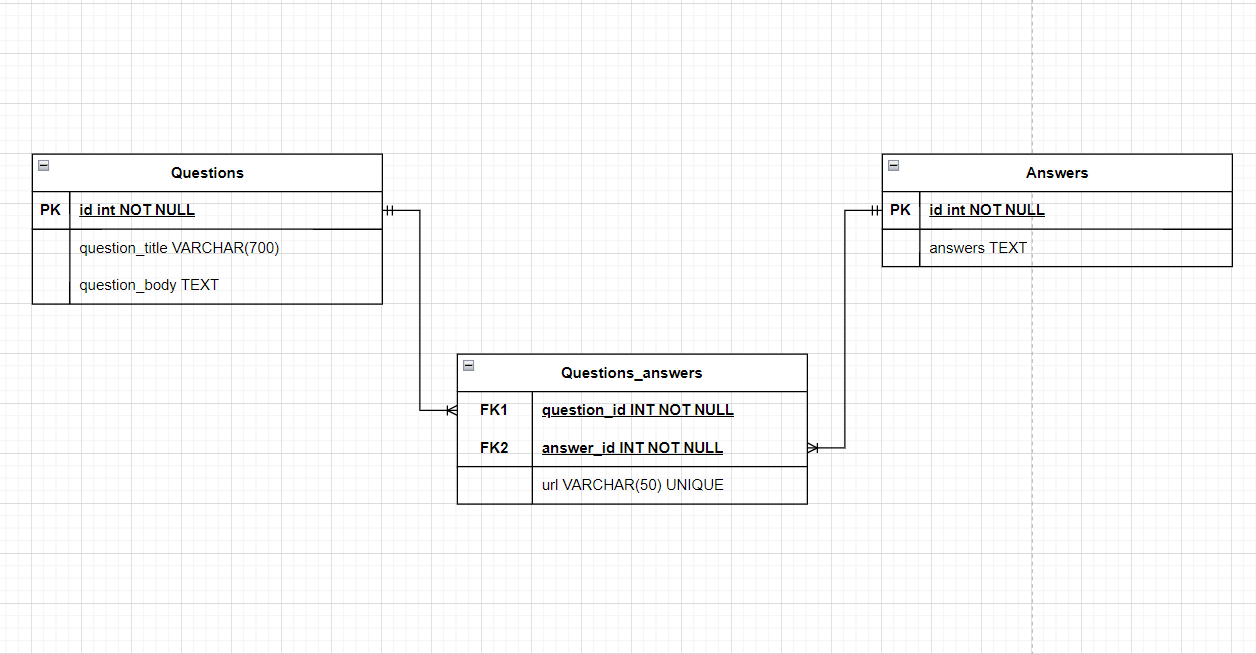

In [6]:
pip install  mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.1 MB 6.7 MB/s eta 0:00:03
   --------------------------------- ------ 13.6/16.1 MB 42.7 MB/s eta 0:00:01
   ---------------------------------------- 16.1/16.1 MB 34.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import mysql.connector
import pandas as pd
from getpass import getpass
from mysql.connector import connect, Error

In [35]:
from mysql.connector import connect, Error
try:
    with connect(
        host="localhost",
        user="root",   
        password="T8xXSnKJ" 
    ) as connection:
        print("Соединение успешно установлено:", connection)
except Error as e:
    print("Ошибка подключения:", e)

Ошибка подключения: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)


In [55]:
# Разделяем DataFrame
questions = df_cleaned[['question_title', 'question_body', 'qbody_keyword_1', 'qbody_keyword_2', 'qbody_keyword_3']].reset_index(drop=True).dropna()
answers = df_cleaned[['answers', 'answers_keyword_1', 'answers_keyword_2', 'answers_keyword_3']].reset_index(drop=True).dropna()
questions['id'] = range(1, len(questions) + 1)
answers['id'] = range(1, len(answers) + 1)
# Проверка результата
questions


,question_title,question_body,qbody_keyword_1,qbody_keyword_2,qbody_keyword_3,id
0,Тест от психолога,спрашивает: Нина (неуказан)Здравствуйте! Для ч...,все,мы,изза,1
1,Помогите разобраться,спрашивает: Евгений (неуказан)Здравствуйте.Мен...,всего,вообще,жены,2
2,Постоянно думаю о прошлом и не знаю что делать,спрашивает: Лера (Москва)Я рассталась со своим...,появляется,вижу,или,3
3,Как научиться снова доверять жене?,спрашивает: Александр (неуказан)Наткнулся на п...,меня,что,это,4
4,Аутоагрессия,спрашивает: василиса (Москва)Здравствуйте Ольг...,нее,что,сильно,5
...,...,...,...,...,...,...
9928,Как понять природу такой социофобии и как от н...,спрашивает: Виталий (Нижний Новгород)Добрый де...,он,нем,его,9929
9929,Проблема с проявлением эмоций,"спрашивает: Евгения (Новосибирск)Здравствуйте,...",человеком,другим,он,9930
9930,"Не знаю, зачем жить. Апатия. Нет энергии.",спрашивает: Анастасия (Санкт-Петербург)Здравст...,помощь,раз,или,9931
9931,"Конфликт между мной, сыном, моей женой и его м...",спрашивает: Сергей Павлович (Пермь)Чтобы избеж...,год,двух,которым,9932


In [56]:
import pandas as pd

# 2. Создание таблицы questions_answers
questions_answers = df_cleaned[['url']].copy()  # Берем только URL
questions_answers['question_id'] = questions['id']  # ID из таблицы Questions
questions_answers['answer_id'] = answers['id']  # ID из таблицы Answers
questions_answers = questions_answers.dropna()


print("\nQuestions_Answers Table:")
questions_answers


Questions_Answers Table:


,url,question_id,answer_id
2,https://psiholog.ru/vopros/4,3.0,3.0
3,https://psiholog.ru/vopros/3,4.0,4.0
4,https://psiholog.ru/vopros/6,5.0,5.0
6,https://psiholog.ru/vopros/5,7.0,7.0
7,https://psiholog.ru/vopros/8,8.0,8.0
...,...,...,...
9924,https://psiholog.ru/vopros/9924,9925.0,9925.0
9925,https://psiholog.ru/vopros/9926,9926.0,9926.0
9926,https://psiholog.ru/vopros/9927,9927.0,9927.0
9930,https://psiholog.ru/vopros/9928,9931.0,9931.0


In [ ]:
# Создание таблиц (если еще не созданы)
with engine.connect() as conn:
    conn.execute("CREATE DATABASE IF NOT EXISTS psychologist_db;")
    conn.execute("""
        CREATE TABLE IF NOT EXISTS Questions (
            id INT AUTO_INCREMENT PRIMARY KEY,
            question_title VARCHAR(700),
            question_body TEXT,
            qbody_keyword_1 VARCHAR(200), 
            qbody_keyword_2 VARCHAR(200), 
            qbody_keyword_3 VARCHAR(200)
        );
    """)
    conn.execute("""
        CREATE TABLE IF NOT EXISTS Answers (
            id INT AUTO_INCREMENT PRIMARY KEY,
            answers TEXT,
            answers_keyword_1 VARCHAR(200), 
            answers_keyword_2 VARCHAR(200), 
            answers_keyword_3 VARCHAR(200)
        );
    """)
    conn.execute("""
        CREATE TABLE IF NOT EXISTS questions_answers (
            question_id INT NOT NULL,
            answer_id INT NOT NULL,
            url VARCHAR(50) UNIQUE,
            FOREIGN KEY (question_id) REFERENCES Questions(id),
            FOREIGN KEY (answer_id) REFERENCES Answers(id)
        );
    """)

In [ ]:

# Загрузка данных
questions.to_sql('Questions', con=engine, if_exists='append', index=False)
answers.to_sql('Answers', con=engine, if_exists='append', index=False)
questions_answers.to_sql('questions_answers', con=engine, if_exists='append', index=False)

Простой запрос

In [ ]:
import mysql.connector as con

connection = con.connect(
      host="localhost",  
      user="root",  
      password="T8xXSnKJ",
      database='psychologist_db'
)
cursor = connection.cursor()
easy = """
            SELECT Questions.question_title, Questions.question_body, Answers.answer
            FROM Questions q
            JOIN questions_answers q_a on q.id = q_a.question_id
            JOIN Answers a ON q_a.answer_id = a.id
            WHERE qbody_keyword_1 = 'депрессия' or qbody_keyword_2 = 'смерть' or qbody_keyword_3 = 'работа';
            """

cursor.execute(easy)

data = cursor.fetchall()

easy_query = pd.DataFrame(data, columns=['question_title', 'question_body', 'answer'])
easy_query

In [ ]:
import mysql.connector as con

connection1 = con.connect(
      host="localhost",  
      user="root",  
      password="T8xXSnKJ",
      database='psychologist_db'
)
cursor1 = connection1.cursor()
medium = """
            SELECT qbody_keyword_1, count(qbody_keyword_1) as summa_q_theme,
            answers_keyword_1, count(answers_keyword_1) as summa_a_theme
            FROM Questions q
            JOIN questions_answers q_a on q.id = q_a.question_id
            JOIN Answers a ON q_a.answer_id = a.id
            group by qbody_keyword_1, answers_keyword_1
            order by count(qbody_keyword_1) desc, count(answers_keyword_1) desc
            """

cursor1.execute(medium)

data1 = cursor1.fetchall()

medium_query = pd.DataFrame(data1, columns=['qbody_keyword_1', 'summa_q_theme', 'answers_keyword_1', 'summa_a_theme'])
medium_query